<a href="https://colab.research.google.com/github/BankNatchapol/Neuromorphic-Computing/blob/main/sound-localization/surrogate_sound_localization_modify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference : https://neural-reckoning.github.io/cosyne-tutorial-2022/

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
my_computer_is_slow = True # set this to True if using Colab

# **Input Generator**

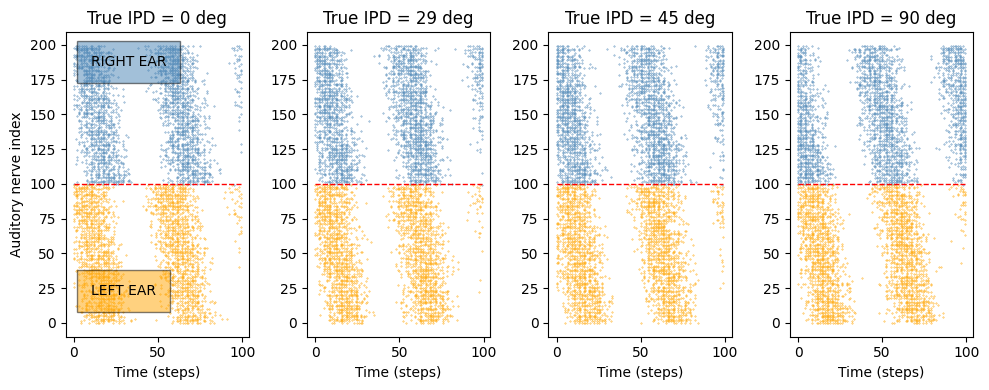

In [2]:
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

# Stimulus and simulation parameters
dt = 1*ms            # large time step to make simulations run faster for tutorial
anf_per_ear = 100    # repeats of each ear with independent noise
envelope_power = 2   # higher values make sharper envelopes, easier
rate_max = 600*Hz    # maximum Poisson firing rate
f = 20*Hz            # stimulus frequency
duration = .1*second # stimulus duration
duration_steps = int(np.round(duration/dt))
input_size = 2*anf_per_ear

# Generate an input signal (spike array) from array of true IPDs
def input_signal(ipd):
    np.random.seed(888)
    num_samples = len(ipd)
    T = np.arange(duration_steps)*dt # array of times
    phi = 2*np.pi*(f*T+np.random.rand()) # array of phases corresponding to those times with random offset
    # each point in the array will have a different phase based on which ear it is
    # and its delay
    theta = np.zeros((num_samples, duration_steps, 2*anf_per_ear))
    # for each ear, we have anf_per_ear different phase delays from to pi/2 so
    # that the differences between the two ears can cover the full range from -pi/2 to pi/2
    phase_delays = np.linspace(0, np.pi/2, anf_per_ear)
    # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
    # but implements the idea in the text above.
    theta[:, :, :anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
    theta[:, :, anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
    # now generate Poisson spikes at the given firing rate as in the previous notebook
    spikes = np.random.rand(num_samples, duration_steps, 2*anf_per_ear)<rate_max*dt*(0.5*(1+np.sin(theta)))**envelope_power
    return spikes

# Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
def random_ipd_input_signal(num_samples, tensor=True):
    ipd = np.random.rand(num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
    spikes = input_signal(ipd)
    if tensor:
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes

def fixed_ipd_input_signal(ipd_list, tensor=True):
    spikes = input_signal(ipd_list)
    if tensor:
        ipd = torch.tensor(ipd_list, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
    return ipd, spikes

# Plot a few just to show how it looks
fixed_input = np.array([0] + [np.pi/(2*i) for i in range(3, 0, -1)])
ipd, spikes = fixed_ipd_input_signal(fixed_input)
# ipd, spikes = random_ipd_input_signal(8)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(4):
    plt.subplot(1, 4, i+1)
    # plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
    where = np.where(spikes[i, :, :].T.cpu() == 1)
    last_index = np.where(where[0]<anf_per_ear)[0][-1]
    plt.scatter(where[1][last_index:], where[0][last_index:], s=0.1, color='steelblue');
    plt.scatter(where[1][:last_index], where[0][:last_index], s=0.1, color='orange');
    plt.plot([anf_per_ear]*duration_steps, '--', color='red', linewidth=1)
    plt.title(f'True IPD = {int(ipd[i]*180/np.pi)} deg')
    if len(ipd)<5:
        plt.xlabel('Time (steps)')
    if i>=4:
        plt.xlabel('Time (steps)')
    if i%4==0:
        plt.ylabel('Auditory nerve index')
        plt.text(10, 20, 'LEFT EAR', color='black',
        bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})
        plt.text(10, 185, 'RIGHT EAR', color='black',
        bbox={'facecolor': 'steelblue', 'alpha': 0.5, 'pad': 10})
plt.tight_layout()

<img src="https://github.com/BankNatchapol/Neuromorphic-Computing/blob/main/images/input_generator_diagram.png?raw=true" alt="drawing" width="800"/>


# **Discretise**

$N_c$ = จำนวน Class ที่จะทำ Classification \
 
{ 
<br>
  $-\frac{\pi}{2}$ : 0, \
  $-\frac{\pi}{2}+\frac{\pi}{N_c-1}$ : 1, \
  . \
  . \
  ., \
  $-\frac{\pi}{2}+\frac{i \pi}{N_c-1}$ : $i$, \
  . \
  . \
  ., \
  $\frac{\pi}{2}$ : $N_c-1$

}

In [3]:
# classes at 15 degree increments
num_classes = 180//10
print(f'Number of classes = {num_classes}')

def discretise(ipds):
    return ((ipds+np.pi/2)*num_classes/np.pi).long() # assumes input is tensor

def continuise(ipd_indices): # convert indices back to IPD midpoints
    return (ipd_indices+0.5)/num_classes*np.pi-np.pi/2

Number of classes = 18


# **Membrane only (no spiking neurons)**

LIF Model

$V\leftarrow \alpha V + Ws$ 

$V$ : Membrane potential

$\alpha$ : Exponential decay coefficient

$W$ : Synaptic weight (\*\* Optimized Parameter)

$s$ : if spike s=1 if no spike s=0

No fire

**Exponential Decay** \
<center>

$\tau \frac{dV}{dt} =  -V$

$\quad \frac{1}{V} dV = -\frac{1}{\tau}dt$

$\quad\quad\;\;\; \int \frac{1}{V} dV = \int -\frac{1}{\tau}dt$

$\quad\quad\;\; ln(V) = -\frac{t}{\tau} + c$

$\quad\quad e^{ln(V)} = e^{-t/\tau + c}$

$\quad\quad\quad\quad\quad\quad\quad\quad\quad\; V(t) = e^c e^{-t/\tau}$ : $V(0) = e^c e^{0} = e^c$

\

<font color='blue'>$\quad\quad\quad V(t) = V(0) e^{-t/\tau}$</font>

\


$\quad\quad\quad\quad\quad\quad\;\; V(t+dt) = V(0) e^{-(t+dt)/\tau}$\
$\quad\quad\quad\quad\quad\quad\quad\; V(t+dt) = V(0)e^{-t/\tau} e^{-dt/\tau} $

\

<font color='red'>$\quad\quad\quad\quad\quad\; V(t+dt) = V(t) e^{-dt/\tau} $</font>


</center>

$\therefore V(t+dt) = \alpha V(t), \quad \alpha = e^{-dt/\tau}$


In [4]:
# Weights and uniform weight initialisation
def init_weight_matrix():
    # Note that the requires_grad=True argument tells PyTorch that we'll be computing gradients with
    # respect to the values in this tensor and thereby learning those values. If you want PyTorch to
    # learn some gradients, make sure it has this on.
    W = nn.Parameter(torch.empty((input_size, num_classes), device=device, dtype=dtype, requires_grad=True))
    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(W)
    bound = 1 / np.sqrt(fan_in)
    nn.init.uniform_(W, 0, bound)
    return W

# Run the simulation
def membrane_only(batch_size, input_spikes, W, tau=20*ms):
    # Input has shape (batch_size, duration_steps, input_size)
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    # v_rec will store the membrane in each time step
    v_rec = [v]
    # Batch matrix multiplication all time steps
    # Equivalent to matrix multiply input_spikes[b, :, :] x W for all b, but faster
    h = torch.einsum("abc,cd->abd", (input_spikes, W))
    # precalculate multiplication factor
    alpha = np.exp(-dt/tau)
    # Update membrane and spikes one time step at a time
    for t in range(duration_steps - 1):
        v = alpha*v + h[:, t, :]
        v_rec.append(v)
    # return the recorded membrane potentials stacked into a single tensor
    v_rec = torch.stack(v_rec, dim=1)  # (batch_size, duration_steps, num_classes)
    return v_rec

<img src="https://github.com/BankNatchapol/Neuromorphic-Computing/blob/main/images/membrane_only.png?raw=true" width="700">

LIF output size:  [4, 100, 18]


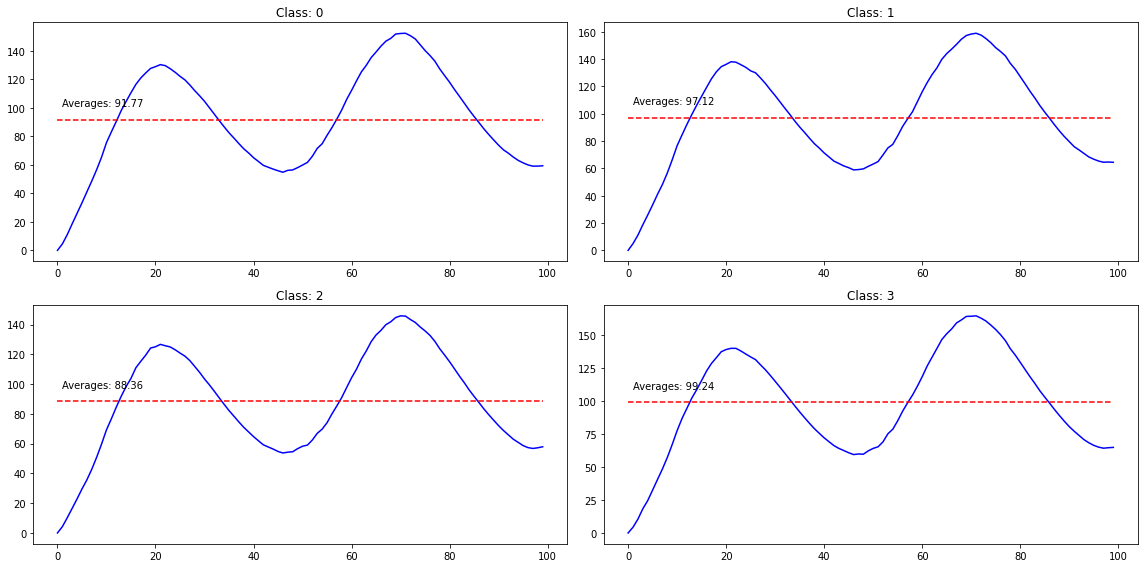

In [5]:
batch_size = 4
W = init_weight_matrix()
ipd, spikes = fixed_ipd_input_signal(fixed_input)
output = membrane_only(batch_size, spikes, W)
print('LIF output size: ', list(output.size()))
plt.figure(figsize=(16, 8))
for i in range(4):
  plt.subplot(2, 2, i+1)
  plt.plot(output[1, :, i].cpu().detach().numpy(), color='blue')
  average = torch.mean(output, 1)[1, i].cpu().detach().numpy()
  plt.plot(range(output.shape[1]), [average]*output.shape[1], '--', color='red')
  plt.text(1, average + 0.1*abs(average), f"Averages: {average:.2f}")
  plt.title(f"Class: {i}")
plt.tight_layout()

In [6]:
class_mean = 0
mean = torch.mean(output[[1]], 1)
print(f'Class {class_mean} mean     : ', round(mean[0][class_mean].tolist(), 2))
print(f'Class {class_mean} mean size: ', list(mean.size()))

Class 0 mean     :  91.77
Class 0 mean size:  [1, 18]


# **Training**

<img src="https://github.com/BankNatchapol/Neuromorphic-Computing/blob/main/images/no_spiking_training.png?raw=true" width="700"  align="right">

In [7]:
 # Parameters for training. These aren't optimal, but instead designed
# to give a reasonable result in a small amount of time for the tutorial!
batch_size = 64
n_training_batches = 64
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# Generator function iterates over the data in batches
# We randomly permute the order of the data to improve learning
def data_generator(ipds, spikes):
    perm = torch.randperm(spikes.shape[0])
    spikes = spikes[perm, :, :]
    ipds = ipds[perm]
    n, _, _ = spikes.shape
    n_batch = n//batch_size
    for i in range(n_batch):
        x_local = spikes[i*batch_size:(i+1)*batch_size, :, :]
        y_local = ipds[i*batch_size:(i+1)*batch_size]
        yield x_local, y_local

print('Input size: ', num_samples)
print('Batch size: ', batch_size)

Input size:  4096
Batch size:  64


Want loss for epoch 1 to be about 2.89, multiply m by constant to get this
Epoch 1: loss=7.08540
Epoch 2: loss=3.17982
Epoch 3: loss=3.04917
Epoch 4: loss=2.98853
Epoch 5: loss=2.76680
Epoch 6: loss=2.85015
Epoch 7: loss=2.62788
Epoch 8: loss=2.74964
Epoch 9: loss=2.52867
Epoch 10: loss=2.51736


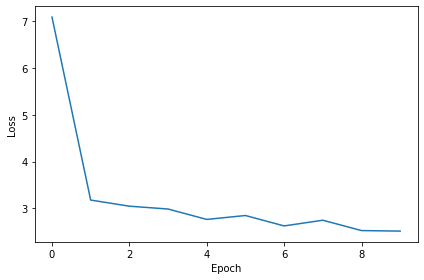

In [8]:
# Training parameters
nb_epochs = 10 # quick, it won't have converged
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes = random_ipd_input_signal(num_samples)

# Initialise a weight matrix
W = init_weight_matrix()

# Optimiser and loss function
optimizer = torch.optim.Adam([W], lr=lr)
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.CrossEntropyLoss() # loss function

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
#a = []
for e in range(nb_epochs):
    local_loss = []
    for x_local, y_local in data_generator(discretise(ipds), spikes):
        # Run network
        output = membrane_only(batch_size, x_local, W)
        # Compute cross entropy loss
        m = torch.mean(output, 1)  # Sum time dimension
        loss = loss_fn(m, y_local)
        local_loss.append(loss.item())
        # Update gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #a.append(W[0][0].cpu().detach().numpy().item())
    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

Chance accuracy level: 5.6%

Train classifier accuracy: 22.5%
Train absolute error: 19.3 deg

Test classifier accuracy: 17.3%
Test absolute error: 20.2 deg


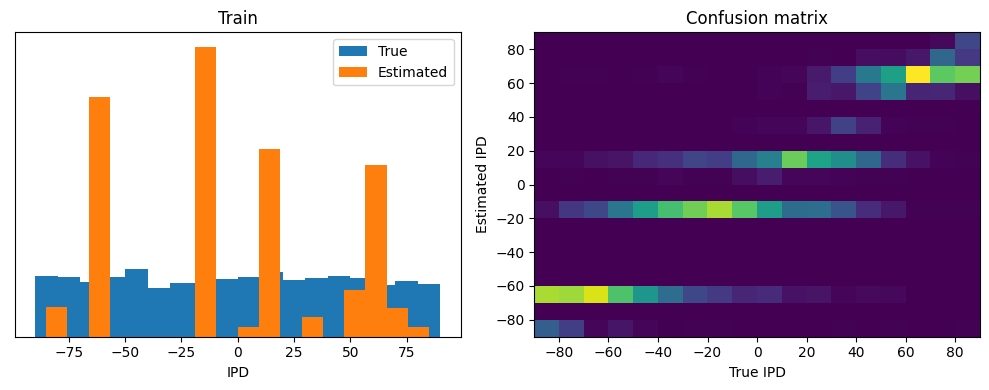

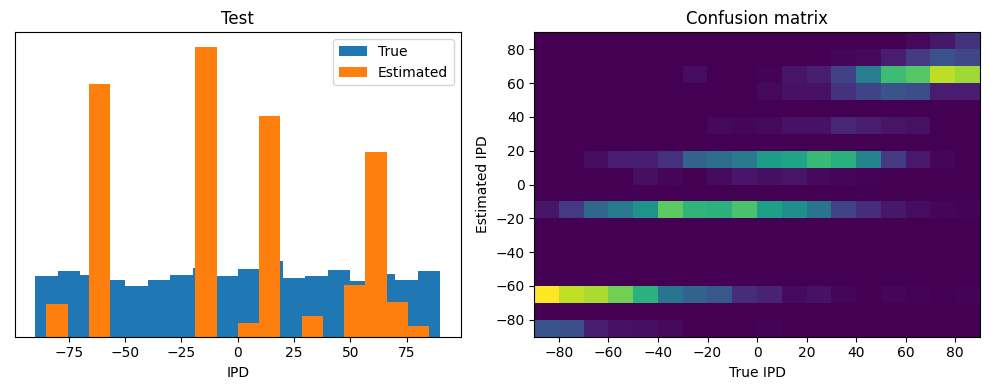

In [9]:
def analyse(ipds, spikes, label, run):
    accs = []
    ipd_true = []
    ipd_est = []
    confusion = np.zeros((num_classes, num_classes))
    for x_local, y_local in data_generator(ipds, spikes):
        y_local_orig = y_local
        y_local = discretise(y_local)
        output = run(x_local)
        m = torch.sum(output, 1)  # Sum time dimension
        _, am = torch.max(m, 1)  # argmax over output units
        tmp = np.mean((y_local == am).detach().cpu().numpy())  # compare to labels
        for i, j in zip(y_local.detach().cpu().numpy(), am.detach().cpu().numpy()):
            confusion[j, i] += 1
        ipd_true.append(y_local_orig.cpu())
        ipd_est.append(continuise(am.detach().cpu().numpy()))
        accs.append(tmp)
    ipd_true = np.hstack(ipd_true)
    ipd_est = np.hstack(ipd_est)
    abs_errors_deg = abs(ipd_true-ipd_est)*180/np.pi
    print()
    print(f"{label} classifier accuracy: {100*np.mean(accs):.1f}%")
    print(f"{label} absolute error: {np.mean(abs_errors_deg):.1f} deg")

    plt.figure(figsize=(10, 4), dpi=100)
    plt.subplot(121)
    plt.hist(ipd_true*180/np.pi, bins=num_classes, label='True')
    plt.hist(ipd_est*180/np.pi, bins=num_classes, label='Estimated')
    plt.xlabel("IPD")
    plt.yticks([])
    plt.legend(loc='best')
    plt.title(label)
    plt.subplot(122)
    confusion /= np.sum(confusion, axis=0)[np.newaxis, :]
    plt.imshow(confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
    plt.xlabel('True IPD')
    plt.ylabel('Estimated IPD')
    plt.title('Confusion matrix')
    plt.tight_layout()    

print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: membrane_only(batch_size, x, W)
analyse(ipds, spikes, 'Train', run=run_func)
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)

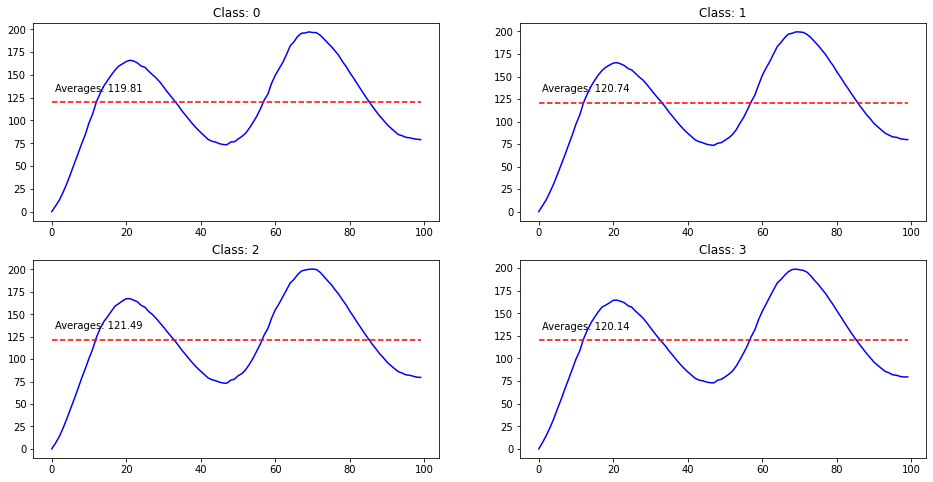

In [10]:
plt.figure(figsize=(16, 8))
for i in range(4):
  plt.subplot(2, 2, i+1)
  plt.plot(output[1, :, i].cpu().detach().numpy(), color='blue')
  average = torch.mean(output, 1)[1, i].cpu().detach().numpy()
  plt.plot(range(output.shape[1]), [average]*output.shape[1], '--', color='red')
  plt.text(1, average + 0.1*abs(average), f"Averages: {average:.2f}")
  plt.title(f"Class: {i}")
#plt.tight_layout()

# **Spiking Model**

Add fire function \
$if \;\; V > V_{threshold}$\
$\;\;\;\;\; V \gets 0$

<img src="https://github.com/BankNatchapol/Neuromorphic-Computing/blob/main/images/snn.png?raw=true" width="800">

In [11]:
# Run the simulation
def snn(batch_size, input_spikes, W, tau=5*ms):
    v = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    s = torch.zeros((batch_size, num_classes), device=device, dtype=dtype)
    v_rec = [v]
    s_rec = [s]
    h = torch.einsum("abc,cd->abd", (input_spikes, W))
    alpha = np.exp(-dt/tau)
    for t in range(duration_steps - 1):
        new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
        s = spike_fn(v-1) # threshold of 1
        v = new_v
        v_rec.append(v)
        s_rec.append(s)

    v_rec = torch.stack(v_rec, dim=1)
    s_rec = torch.stack(s_rec, dim=1)
    return s_rec

Surrogate Gradient

forward using Heaviside function (H) </br>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d9/Dirac_distribution_CDF.svg/325px-Dirac_distribution_CDF.svg.png" >

$H(V-1): if \;\; V>0 \;\; then \;\; 1 \;\; else \;\; 0$
</br>
</br>
backward using smoothed function (S) (e.g. Sigmoid function)</br>
<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0378475415002554-gr1.jpg" >

$S(V) = \frac{1}{1+e^{-V}}$

$S'(V) = S(V)(1-S(V))$



In [ ]:
beta = 5

class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply

LIF output size:  [4, 100, 18]


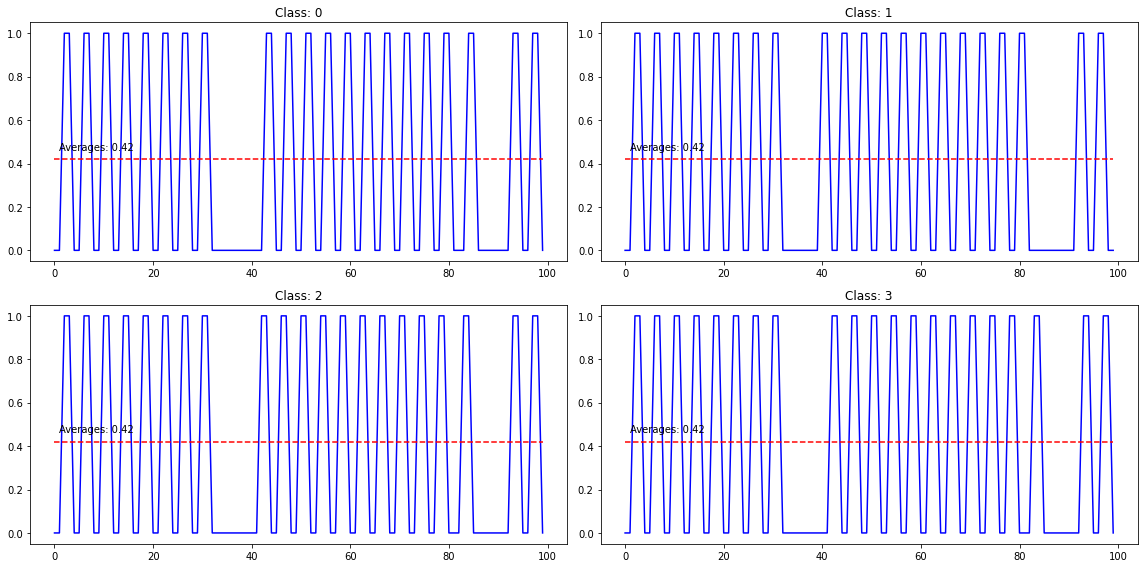

In [ ]:
batch_size = 4
W = init_weight_matrix()
ipd, spikes = fixed_ipd_input_signal(fixed_input)
output  = snn(batch_size, spikes, W)
print('LIF output size: ', list(output.size()))
plt.figure(figsize=(16, 8))
for i in range(4):
  plt.subplot(2, 2, i+1)
  plt.plot(output[1, :, i].cpu().detach().numpy(), color='blue')
  average = torch.mean(output, 1)[1, i].cpu().detach().numpy()
  plt.plot(range(output.shape[1]), [average]*output.shape[1], '--', color='red')
  plt.text(1, average + 0.1*abs(average), f"Averages: {average:.2f}")
  plt.title(f"Class: {i}")
plt.tight_layout()

<img src="https://github.com/BankNatchapol/Neuromorphic-Computing/blob/main/images/spiking_training.png?raw=true" width="700"  align="right">

Want loss for epoch 1 to be about 2.89, multiply m by constant to get this
Epoch 1: loss=2.82693
Epoch 2: loss=2.78276
Epoch 3: loss=2.77487
Epoch 4: loss=2.76938
Epoch 5: loss=2.76574
Epoch 6: loss=2.76297
Epoch 7: loss=2.76142
Epoch 8: loss=2.75906
Epoch 9: loss=2.75734
Epoch 10: loss=2.75631


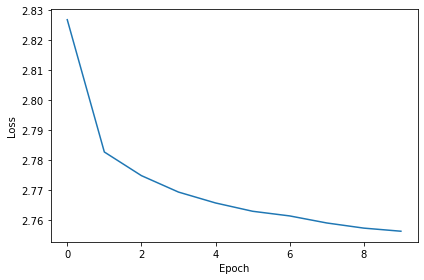

In [ ]:
batch_size = 64
n_training_batches = 64
n_testing_batches = 32
num_samples = batch_size*n_training_batches

# Training parameters
nb_epochs = 10 # quick, it won't have converged
lr = 0.01 # learning rate

# Generate the training data
ipds, spikes = random_ipd_input_signal(num_samples)

# Initialise a weight matrix
W = init_weight_matrix()

# Optimiser and loss function
optimizer = torch.optim.Adam([W], lr=lr)
loss_fn = nn.CrossEntropyLoss() # loss function

print(f"Want loss for epoch 1 to be about {-np.log(1/num_classes):.2f}, multiply m by constant to get this")

loss_hist = []
#a = []
for e in range(nb_epochs):
    local_loss = []
    for x_local, y_local in data_generator(discretise(ipds), spikes):
        # Run network
        output  = snn(batch_size, x_local, W)
        # Compute cross entropy loss
        m = torch.mean(output, 1)  # Sum time dimension ? sum or mean is better
        loss = loss_fn(m, y_local)
        local_loss.append(loss.item())
        # Update gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #a.append(W[0][0].cpu().detach().numpy().item())
    loss_hist.append(np.mean(local_loss))
    print("Epoch %i: loss=%.5f"%(e+1, np.mean(local_loss)))

# Plot the loss function over time
plt.plot(loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

Chance accuracy level: 5.6%

Train classifier accuracy: 47.4%
Train absolute error: 6.9 deg

Test classifier accuracy: 43.3%
Test absolute error: 7.3 deg


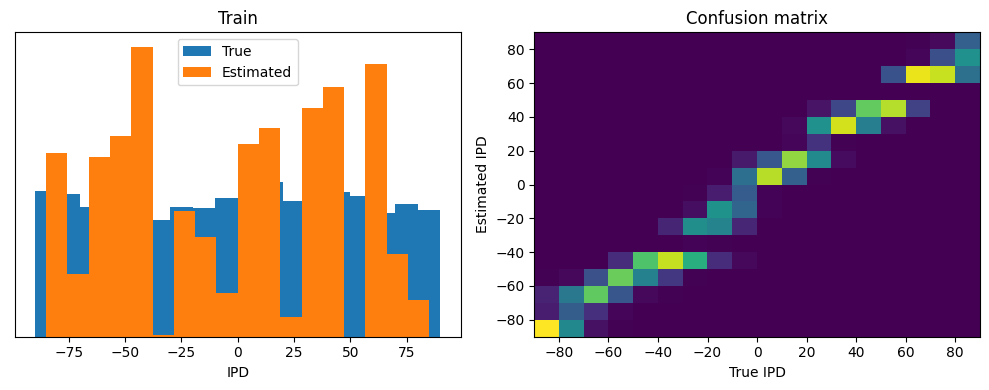

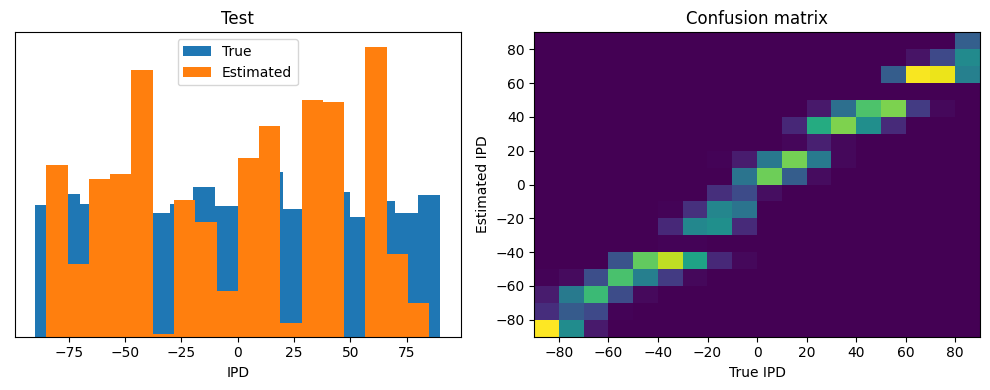

In [ ]:
print(f"Chance accuracy level: {100*1/num_classes:.1f}%")
run_func = lambda x: snn(batch_size, x, W)
analyse(ipds, spikes, 'Train', run=run_func)
ipds_test, spikes_test = random_ipd_input_signal(batch_size*n_testing_batches)
analyse(ipds_test, spikes_test, 'Test', run=run_func)

LIF output size:  [4096, 100, 18]
Target Class   :  15
Predicted Class:  15


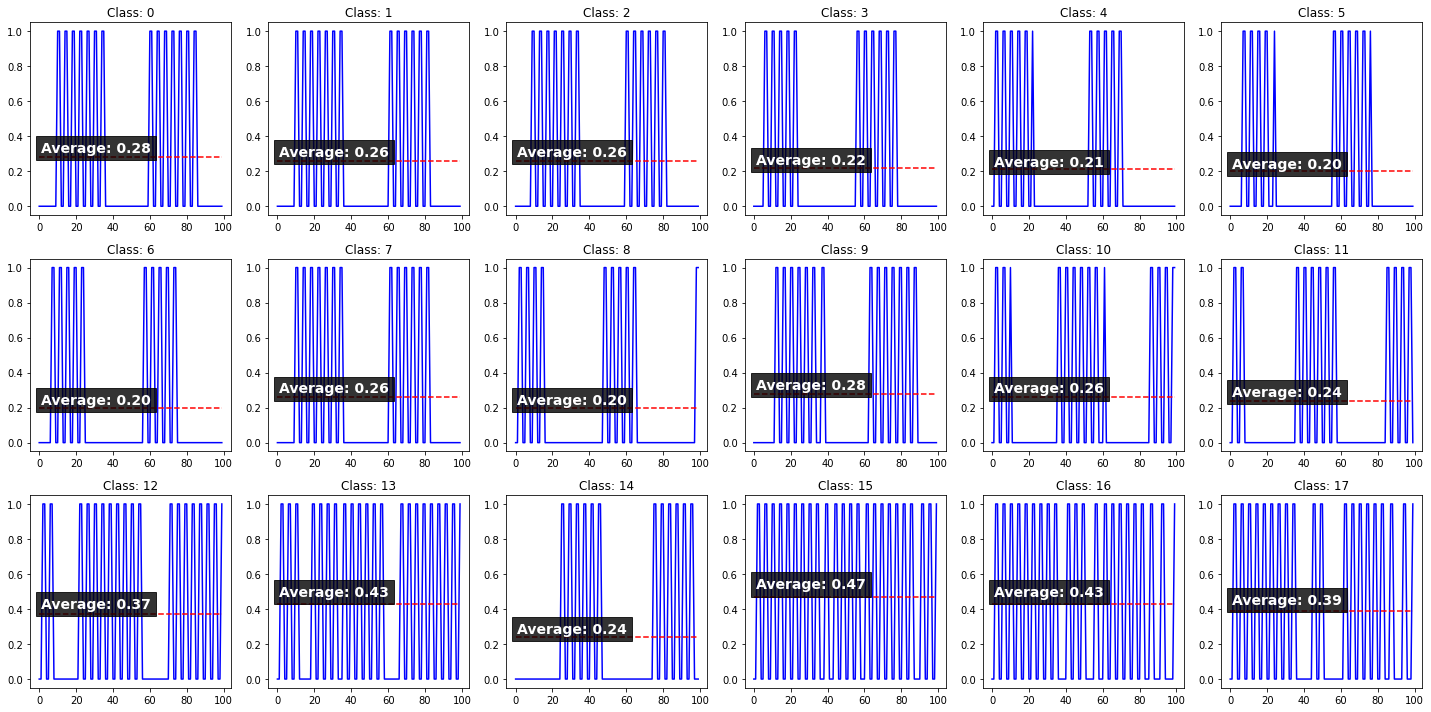

In [ ]:
sample_number = 111
output  = snn(num_samples, spikes, W)
print('LIF output size: ', list(output.size()))
print('Target Class   : ', discretise(ipds[sample_number]).item())
_, am = torch.max(torch.mean(output[[sample_number]], 1), 1)
print('Predicted Class: ', *am.tolist())

plt.figure(figsize=(20, 10))
for i in range(18):
  plt.subplot(3, 6, i+1)
  plt.plot(output[sample_number, :, i].cpu().detach().numpy(), color='blue')
  average = torch.mean(output, 1)[sample_number, i].cpu().detach().numpy()
  # summation = torch.sum(output, 1)[sample_number, i].cpu().detach().numpy()
  plt.plot(range(output.shape[1]), [average]*output.shape[1], '--', color='red')
  plt.text(1, average + 0.1*abs(average), f"Average: {average:.2f}",
        bbox={'facecolor': 'black', 'alpha': 0.8, 'pad': 5}, 
        color='white', weight='bold', fontsize=14)
  plt.title(f"Class: {i}")
plt.tight_layout()
